In [23]:
import os
import sys
import csv
import pandas as pd
import numpy as np

import os.path
from os import path

import openslide
from skimage.color import rgb2hsv
import PIL
from PIL import Image

import cv2
import glob
import h5py
import os
import pathlib
import tables

import torch
from skimage import io, transform
from sklearn import metrics
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from matplotlib import pyplot

import torch
import timm
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import time
import torch.nn.functional as F
import torch.nn as nn
from torch.nn.functional import kl_div, softmax, log_softmax

In [2]:
hdf5_path = '/home/irene/Downloads/luadlusc.hdf5'
file = h5py.File(hdf5_path, "r")
file.keys()

<KeysViewHDF5 ['test_img', 'test_label', 'train_img', 'train_label', 'val_img', 'val_label']>

In [3]:
rgb_mean,rgb_std = (0.485, 0.456, 0.406),(0.229, 0.224, 0.225)

In [4]:
class HDF5Dataset(Dataset):


    def __init__(self, h5_path, set_name, transform = None):
        self.h5_path = h5_path
        self.dataset = None
        self.transform = transform
        self.file_path  = h5_path
        self.set = set_name
        
        str_name = self.set + "_img"
        
        file = h5py.File(h5_path, "r")
        self.dataset_len = len(file[str_name])
        
        self.transform = transforms.Compose([
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.Resize(224),
                transforms.ToTensor(),
                transforms.Normalize(rgb_mean,rgb_std)
            ])
        
    def __getitem__(self, index): #to enable indexing
        
        if self.dataset is None:
            self.imgs = h5py.File(self.file_path, 'r')[self.set + "_img"]
            self.labels = h5py.File(self.file_path, 'r')[self.set + "_label"]
            
            cur_img = self.imgs[index]
            PIL_image = Image.fromarray(np.uint8(cur_img)).convert('RGB')#3 channels don't need alpha channel network input
            image = self.transform(PIL_image)
            label = self.labels[index].astype('float32')
            
            
        return (image,label)

    def __len__(self):
        return self.dataset_len

In [5]:
from torch.utils.data import Dataset,DataLoader

train_loader = DataLoader(HDF5Dataset(h5_path=hdf5_path,set_name="train"), batch_size=8,shuffle=True,drop_last=False)
val_loader = DataLoader(HDF5Dataset(h5_path=hdf5_path,set_name="val"), batch_size=8,shuffle=True,drop_last=False)
test_loader = DataLoader(HDF5Dataset(h5_path=hdf5_path,set_name="test"), batch_size=8,shuffle=True,drop_last=False)

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

out_dim = 2

model = timm.create_model("vgg16", pretrained=True)
model.head.fc = nn.Linear(model.head.fc.in_features, out_dim)

model.to(device)
optimizer = torch.optim.SGD(model.parameters(),lr=0.001,weight_decay = 1e-4,momentum = 0.9)
criterion = nn.CrossEntropyLoss()



def train_valid_model (net,loaders,max_epochs = 20):
    best_acc = 0.0 
    for epoch in range (max_epochs):
        for phase in ['train','val']:
            iterator = iter(loaders[phase])
            total_step = len(loaders[phase])
            print('Phase {}'.format(phase))
            if phase == 'train':
                net.train()
            else:
                net.eval()
                
            running_loss = 0.0
            running_correct = 0
            
            predictions_all = []
            label_all = []
            probs_all = []
            for step in range(total_step-1): #iterate each batch
                images,labels = next(iterator) # CUDA computation
                images = images.to(device)
                labels = labels.to(device)
                labels = labels.long()
                optimizer.zero_grad()
                
                output = net(images)
                loss = criterion(output,labels)
                
                probs = torch.nn.functional.softmax(output, dim=1) # probabilities
                
                running_loss +=loss.item()
                _, preds = torch.max(output.data,1)
                
                running_correct += (preds == labels).sum().item()
                
                if len(predictions_all) == 0:
                    predictions_all = preds.detach().cpu().numpy()
                    label_all = labels.detach().cpu().numpy()
                    probs_all = probs.detach().cpu().numpy()
                else:
                    predictions_all = np.vstack((predictions_all, preds.detach().cpu().numpy()))
                    probs_all = np.vstack((probs_all, probs.detach().cpu().numpy()))
                    label_all = np.vstack((label_all, labels.detach().cpu().numpy()))

                if phase == 'train':
                    loss.backward()
                    optimizer.step()
            
                    
            phase_loss = running_loss / len(loaders[phase])
            phase_acc = running_correct/len(label_all.flatten())
            if phase == 'val':
                y_true = label_all.flatten()
                y_pred = predictions_all.flatten()
                print("validating...")
                print(len(y_true))
                print(len(y_pred))
                print(metrics.classification_report(y_true, y_pred, digits=3))
            if phase == 'val' and phase_acc > best_acc:
                
                best_acc = phase_acc
                import copy 
                
                best_model_state_dict = copy.deepcopy(net.state_dict())
                torch.save(best_model_state_dict,'vgg16best_model.pth')
                
            print('PHASE {} Loss: {:.4f} Acc: {:.4f}'.format(phase, phase_loss, phase_acc))
    net.load_state_dict(best_model_state_dict)
    
    return net 
            
       
print(device)  

cuda


In [52]:
def test_best_model (net, test_loader, a_device = None):
    iterator = iter(test_loader)
    total_step = len(test_loader)
    
    print(total_step)
    net.eval()
    
    with torch.no_grad():
        running_loss = 0
        running_corrects = 0
        
        total_0,total_1 = 0,0
        hit_0 = 0
        hit_1 = 0
        label_all = []
        probs_all = []
        predictions_all = []
        for step in range(total_step-1):
            images,labels = next(iterator)
            images.to(a_device)
            labels.to(a_device)
            total_0 += labels.tolist().count(0)
            total_1 += labels.tolist().count(1)
            print(labels.shape)
            images = images.to(a_device)
            labels = labels.to(device=a_device, dtype=torch.int64)
            labels = labels.long()
            
            output = net(images)
            loss = criterion(output,labels)
            
            probs = torch.nn.functional.softmax(output, dim=1)

            running_loss +=loss.item()
            _, preds = torch.max(output.data,1)
            
            equals = preds == labels.view(*preds.shape)
            if(len(label_all) ==0):
                predictions_all = preds.detach().cpu().numpy()
                label_all = labels.detach().cpu().numpy()
                probs_all = probs.detach().cpu().numpy()
            else:
                predictions_all = np.vstack((predictions_all, preds.detach().cpu().numpy()))
                label_all = np.vstack((label_all, labels.detach().cpu().numpy()))
                probs_all = np.vstack((probs_all, probs.detach().cpu().numpy()))

            all_hits = equals.view(equals.shape[0]).tolist() 
            all_corrects = labels[all_hits]
            
            hit_0 += all_corrects.tolist().count(0)
            hit_1 += all_corrects.tolist().count(1)
 
        
            running_corrects += (preds == labels).sum().item()
        print(len(label_all.flatten()))
        label_all = label_all.flatten()
        predictions_all = predictions_all.flatten()
        phase_loss = running_loss / len(test_loader)
        phase_acc = running_corrects/len(label_all.flatten())
        print('Test Loss: {:.4f} Acc: {:.4f}'.format(phase_loss, phase_acc))
        
        print(hit_0, ' / ',total_0)
        print(hit_1, ' / ',total_1)
                
            
    return label_all, probs_all, predictions_all #add this later
                
        #y_test --> label, y_score --> probs all 

In [19]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [8]:
epochs = 10
loaders = dict({'train': train_loader, 'val': val_loader})
for t in range(epochs):
    print(f"Epoch {t+1}\n-----------------------")
    bestmodel = train_valid_model (model,loaders)
    

Epoch 1
-----------------------
Phase train
PHASE train Loss: 0.4826 Acc: 0.7537
Phase val
validating...
9928
9928
              precision    recall  f1-score   support

           0      0.932     0.575     0.711      4529
           1      0.730     0.965     0.831      5399

    accuracy                          0.787      9928
   macro avg      0.831     0.770     0.771      9928
weighted avg      0.822     0.787     0.776      9928

PHASE val Loss: 0.3950 Acc: 0.7870
Phase train
PHASE train Loss: 0.2897 Acc: 0.8707
Phase val
validating...
9928
9928
              precision    recall  f1-score   support

           0      0.901     0.938     0.919      4529
           1      0.946     0.913     0.929      5399

    accuracy                          0.925      9928
   macro avg      0.923     0.926     0.924      9928
weighted avg      0.925     0.925     0.925      9928

PHASE val Loss: 0.1878 Acc: 0.9246
Phase train
PHASE train Loss: 0.1824 Acc: 0.9269
Phase val
validating...
9928


PHASE train Loss: 0.0070 Acc: 0.9979
Phase val
validating...
9928
9928
              precision    recall  f1-score   support

           0      0.991     0.989     0.990      4529
           1      0.991     0.993     0.992      5399

    accuracy                          0.991      9928
   macro avg      0.991     0.991     0.991      9928
weighted avg      0.991     0.991     0.991      9928

PHASE val Loss: 0.0284 Acc: 0.9910
Epoch 2
-----------------------
Phase train
PHASE train Loss: 0.0066 Acc: 0.9977
Phase val
validating...
9928
9928
              precision    recall  f1-score   support

           0      0.953     0.985     0.969      4529
           1      0.987     0.959     0.973      5399

    accuracy                          0.971      9928
   macro avg      0.970     0.972     0.971      9928
weighted avg      0.972     0.971     0.971      9928

PHASE val Loss: 0.1114 Acc: 0.9710
Phase train
PHASE train Loss: 0.0022 Acc: 0.9997
Phase val
validating...
9928
9928
       

PHASE train Loss: 0.0000 Acc: 1.0000
Phase val
validating...
9928
9928
              precision    recall  f1-score   support

           0      0.994     0.995     0.995      4528
           1      0.996     0.995     0.995      5400

    accuracy                          0.995      9928
   macro avg      0.995     0.995     0.995      9928
weighted avg      0.995     0.995     0.995      9928

PHASE val Loss: 0.0210 Acc: 0.9951
Phase train
PHASE train Loss: 0.0000 Acc: 1.0000
Phase val
validating...
9928
9928
              precision    recall  f1-score   support

           0      0.993     0.997     0.995      4529
           1      0.997     0.994     0.996      5399

    accuracy                          0.995      9928
   macro avg      0.995     0.995     0.995      9928
weighted avg      0.995     0.995     0.995      9928

PHASE val Loss: 0.0213 Acc: 0.9954
Epoch 3
-----------------------
Phase train
PHASE train Loss: 0.0000 Acc: 1.0000
Phase val
validating...
9928
9928
       

PHASE train Loss: 0.0000 Acc: 1.0000
Phase val
validating...
9928
9928
              precision    recall  f1-score   support

           0      0.993     0.996     0.994      4529
           1      0.996     0.994     0.995      5399

    accuracy                          0.995      9928
   macro avg      0.995     0.995     0.995      9928
weighted avg      0.995     0.995     0.995      9928

PHASE val Loss: 0.0246 Acc: 0.9947
Phase train
PHASE train Loss: 0.0000 Acc: 1.0000
Phase val
validating...
9928
9928
              precision    recall  f1-score   support

           0      0.993     0.996     0.994      4529
           1      0.996     0.994     0.995      5399

    accuracy                          0.995      9928
   macro avg      0.995     0.995     0.995      9928
weighted avg      0.995     0.995     0.995      9928

PHASE val Loss: 0.0244 Acc: 0.9948
Phase train
PHASE train Loss: 0.0000 Acc: 1.0000
Phase val
validating...
9928
9928
              precision    recall  f1-s

PHASE train Loss: 0.0000 Acc: 1.0000
Phase val
validating...
9928
9928
              precision    recall  f1-score   support

           0      0.992     0.995     0.994      4528
           1      0.996     0.994     0.995      5400

    accuracy                          0.994      9928
   macro avg      0.994     0.994     0.994      9928
weighted avg      0.994     0.994     0.994      9928

PHASE val Loss: 0.0240 Acc: 0.9944
Phase train
PHASE train Loss: 0.0000 Acc: 1.0000
Phase val
validating...
9928
9928
              precision    recall  f1-score   support

           0      0.992     0.995     0.993      4529
           1      0.996     0.993     0.994      5399

    accuracy                          0.994      9928
   macro avg      0.994     0.994     0.994      9928
weighted avg      0.994     0.994     0.994      9928

PHASE val Loss: 0.0244 Acc: 0.9940
Phase train
PHASE train Loss: 0.0000 Acc: 1.0000
Phase val
validating...
9928
9928
              precision    recall  f1-s

PHASE train Loss: 0.0000 Acc: 1.0000
Phase val
validating...
9928
9928
              precision    recall  f1-score   support

           0      0.991     0.995     0.993      4528
           1      0.996     0.992     0.994      5400

    accuracy                          0.994      9928
   macro avg      0.994     0.994     0.994      9928
weighted avg      0.994     0.994     0.994      9928

PHASE val Loss: 0.0258 Acc: 0.9938
Phase train
PHASE train Loss: 0.0000 Acc: 1.0000
Phase val
validating...
9928
9928
              precision    recall  f1-score   support

           0      0.993     0.996     0.994      4529
           1      0.997     0.994     0.995      5399

    accuracy                          0.995      9928
   macro avg      0.995     0.995     0.995      9928
weighted avg      0.995     0.995     0.995      9928

PHASE val Loss: 0.0225 Acc: 0.9950
Phase train
PHASE train Loss: 0.0000 Acc: 1.0000
Phase val
validating...
9928
9928
              precision    recall  f1-s

PHASE train Loss: 0.0000 Acc: 1.0000
Phase val
validating...
9928
9928
              precision    recall  f1-score   support

           0      0.991     0.996     0.993      4529
           1      0.996     0.992     0.994      5399

    accuracy                          0.994      9928
   macro avg      0.994     0.994     0.994      9928
weighted avg      0.994     0.994     0.994      9928

PHASE val Loss: 0.0254 Acc: 0.9939
Phase train
PHASE train Loss: 0.0000 Acc: 1.0000
Phase val
validating...
9928
9928
              precision    recall  f1-score   support

           0      0.992     0.994     0.993      4528
           1      0.995     0.994     0.994      5400

    accuracy                          0.994      9928
   macro avg      0.994     0.994     0.994      9928
weighted avg      0.994     0.994     0.994      9928

PHASE val Loss: 0.0255 Acc: 0.9940
Phase train
PHASE train Loss: 0.0000 Acc: 1.0000
Phase val
validating...
9928
9928
              precision    recall  f1-s

PHASE train Loss: 0.0000 Acc: 1.0000
Phase val
validating...
9928
9928
              precision    recall  f1-score   support

           0      0.991     0.995     0.993      4529
           1      0.996     0.993     0.994      5399

    accuracy                          0.994      9928
   macro avg      0.994     0.994     0.994      9928
weighted avg      0.994     0.994     0.994      9928

PHASE val Loss: 0.0265 Acc: 0.9940
Phase train
PHASE train Loss: 0.0000 Acc: 1.0000
Phase val
validating...
9928
9928
              precision    recall  f1-score   support

           0      0.990     0.994     0.992      4529
           1      0.995     0.992     0.994      5399

    accuracy                          0.993      9928
   macro avg      0.993     0.993     0.993      9928
weighted avg      0.993     0.993     0.993      9928

PHASE val Loss: 0.0277 Acc: 0.9929
Phase train
PHASE train Loss: 0.0163 Acc: 0.9945
Phase val
validating...
9928
9928
              precision    recall  f1-s

PHASE train Loss: 0.0000 Acc: 1.0000
Phase val
validating...
9928
9928
              precision    recall  f1-score   support

           0      0.992     0.996     0.994      4529
           1      0.996     0.993     0.995      5399

    accuracy                          0.994      9928
   macro avg      0.994     0.995     0.994      9928
weighted avg      0.994     0.994     0.994      9928

PHASE val Loss: 0.0239 Acc: 0.9945
Phase train
PHASE train Loss: 0.0000 Acc: 1.0000
Phase val
validating...
9928
9928
              precision    recall  f1-score   support

           0      0.991     0.994     0.993      4529
           1      0.995     0.993     0.994      5399

    accuracy                          0.993      9928
   macro avg      0.993     0.994     0.993      9928
weighted avg      0.993     0.993     0.993      9928

PHASE val Loss: 0.0235 Acc: 0.9935
Phase train
PHASE train Loss: 0.0000 Acc: 1.0000
Phase val
validating...
9928
9928
              precision    recall  f1-s

PHASE train Loss: 0.0000 Acc: 1.0000
Phase val
validating...
9928
9928
              precision    recall  f1-score   support

           0      0.990     0.996     0.993      4528
           1      0.996     0.992     0.994      5400

    accuracy                          0.994      9928
   macro avg      0.993     0.994     0.994      9928
weighted avg      0.994     0.994     0.994      9928

PHASE val Loss: 0.0289 Acc: 0.9936
Phase train
PHASE train Loss: 0.0000 Acc: 1.0000
Phase val
validating...
9928
9928
              precision    recall  f1-score   support

           0      0.991     0.996     0.993      4528
           1      0.997     0.992     0.994      5400

    accuracy                          0.994      9928
   macro avg      0.994     0.994     0.994      9928
weighted avg      0.994     0.994     0.994      9928

PHASE val Loss: 0.0279 Acc: 0.9939
Phase train
PHASE train Loss: 0.0000 Acc: 1.0000
Phase val
validating...
9928
9928
              precision    recall  f1-s

PHASE train Loss: 0.0000 Acc: 1.0000
Phase val
validating...
9928
9928
              precision    recall  f1-score   support

           0      0.991     0.996     0.994      4528
           1      0.997     0.992     0.995      5400

    accuracy                          0.994      9928
   macro avg      0.994     0.994     0.994      9928
weighted avg      0.994     0.994     0.994      9928

PHASE val Loss: 0.0286 Acc: 0.9941
Phase train
PHASE train Loss: 0.0000 Acc: 1.0000
Phase val
validating...
9928
9928
              precision    recall  f1-score   support

           0      0.992     0.994     0.993      4529
           1      0.995     0.994     0.994      5399

    accuracy                          0.994      9928
   macro avg      0.994     0.994     0.994      9928
weighted avg      0.994     0.994     0.994      9928

PHASE val Loss: 0.0261 Acc: 0.9938
Phase train
PHASE train Loss: 0.0000 Acc: 1.0000
Phase val
validating...
9928
9928
              precision    recall  f1-s

In [8]:
model_path = 'vgg16best_model.pth'

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

out_dim = 2

model = timm.create_model("vgg16", pretrained=True)
model.head.fc = nn.Linear(model.head.fc.in_features, out_dim)


In [11]:
my_dict = torch.load(model_path)

In [12]:
model.load_state_dict(my_dict)

<All keys matched successfully>

In [13]:
model.to(device)
optimizer = torch.optim.SGD(model.parameters(),lr=0.001,weight_decay = 1e-4,momentum = 0.9)
criterion = nn.CrossEntropyLoss()

In [53]:
y_test, y_prob, y_pred= test_best_model (model, test_loader, a_device = device)


1242
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
tor

torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Si

torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Si

In [54]:
fpr = dict()
tpr = dict()

fpr, tpr, thresholds = roc_curve(y_test, y_prob[:,1])

In [55]:
print(y_test.shape)
print(y_prob.shape)
print(y_pred.shape)

(9928,)
(9928, 2)
(9928,)


In [56]:
roc_auc = roc_auc_score(y_test, y_prob[:,1])
print('AUC: %.3f' % roc_auc)

AUC: 1.000


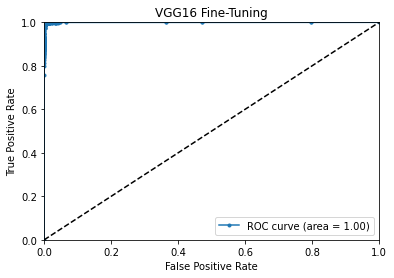

In [57]:
# ROC Curves and AUC
plt.plot(fpr,tpr ,marker='.', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('VGG16 Fine-Tuning')
plt.legend(loc="lower right")
plt.savefig('VGG16 Fine-Tuning.png')

In [60]:
accuracy = accuracy_score(y_test,y_pred,normalize = True)

In [61]:
print(accuracy)

0.9951651893634166


In [63]:
f1 = f1_score(y_test, y_pred)

In [64]:
print(f1)

0.9955547323578441
